# Deblur Photos with DeblurGAN-v2 and OpenVINO

This tutorial demonstrates Single Image Motion Debluring with DeblurGAN-v2 in OpenVINO, by first converting the [VITA-Group/DeblurGANv2](https://github.com/VITA-Group/DeblurGANv2) model to OpenVINO's Intermediate Representation (IR) format. Model information can be found [here](https://docs.openvino.ai/latest/omz_models_model_deblurgan_v2.html).

### What is deblurring?

Deblurring is the task of removing motion blurs that usually occur in photos shot with hand-held cameras when there are moving objects in the scene. Blurs not only reduce the human perception about the quality of the image, but also complicate computer vision analyses. 

Kupyn, O., Martyniuk, T., Wu, J., & Wang, Z. (2019). [Deblurgan-v2: Deblurring (orders-of-magnitude) faster and better.](https://openaccess.thecvf.com/content_ICCV_2019/html/Kupyn_DeblurGAN-v2_Deblurring_Orders-of-Magnitude_Faster_and_Better_ICCV_2019_paper.html) In Proceedings of the IEEE/CVF International Conference on Computer Vision (pp. 8878-8887).

## Preparations

### Imports

In [1]:
import json
import sys
import shutil
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from openvino.runtime import Core

sys.path.append("../utils")
from notebook_utils import load_image

### Settings

In [2]:
# Device to use for inference. For example, "CPU", or "GPU"
DEVICE = "CPU"

# Directory to save the model in
model_dir = Path("model")
model_dir.mkdir(exist_ok=True)

# Output directory
output_dir = Path("output")
output_dir.mkdir(exist_ok=True)

# The name of the Open Model Zoo model
model_name = "deblurgan-v2"
model_xml_path = model_dir / Path(f"{model_name}.xml")

precision = "FP16"
base_model_dir = Path("~/open_model_zoo_models").expanduser()
omz_cache_dir = Path("~/open_model_zoo_cache").expanduser()

### Download DeblurGAN-v2 Model from Open Model Zoo

**NOTE:** The converted DeblurGAN-v2 Model in the OpemVINO IR format is already in the `model` directory. You can skip the following sections and move to loading the model.

In [ ]:
download_command = (
    f"omz_downloader --name {model_name} --output_dir {base_model_dir} --cache_dir {omz_cache_dir}"
)
display(Markdown(f"Download command: `{download_command}`"))
display(Markdown(f"Downloading {model_name}..."))
! $download_command

### Convert DeblurGAN-v2 Model to OpenVINO IR format

Model Conversion may take a while. Conversion succeeded if the last lines of the output include `[ SUCCESS ] Generated IR version 11 model`.

In [ ]:
convert_command = f"omz_converter --name {model_name} --precisions {precision} --download_dir {base_model_dir} --output_dir {base_model_dir}"
display(Markdown(f"Convert command: `{convert_command}`"))
display(Markdown(f"Converting {model_name}..."))

! $convert_command

### Copy Model

Copy the DeblurGAN-v2 Model to the specified `model_dir` directory in the settings.

In [ ]:
model_info = %sx omz_info_dumper --name $model_name

In [ ]:
model_info_json = json.loads(model_info.get_nlstr())[0]

In [ ]:

model_downloaded_dir =  (
    base_model_dir 
    / Path(model_info_json["subdirectory"])
    / Path(precision)
)

for model_file in model_downloaded_dir.iterdir():
    try:
        shutil.copyfile(model_file, model_dir / model_file.name)
    except FileExistsError:
        pass

## Load the Model

Load and compile the DeblurGAN-v2 model in the Inference Engine with `ie.read_model` and compile it for the specified device with `ie.compile_model`. Get input and output keys and the expected input shape for the model.

In [3]:
ie = Core()
model = ie.read_model(model=model_xml_path)
compiled_model = ie.compile_model(model=model, device_name=DEVICE)

In [4]:
model_input_layer = next(iter(compiled_model.inputs))
model_output_layer = next(iter(compiled_model.outputs))

In [5]:
model_input_layer

<ConstOutput: names[blur_image] shape{1,3,736,1312} type: f32>

In [6]:
model_output_layer

<ConstOutput: names[deblur_image] shape{1,3,736,1312} type: f32>

## Deblur Image

### Load, resize and reshape input image

The input image is read using the default `load_image` function from notebooks.utils, resized to meet the network's expected input sizes, and reshaped to (N, C, H, W), where N=number of images in the batch, C=number of channels, H=height, and W=width.

In [7]:
# Load input image
image = load_image("data/blur/000144_19.png")

# N,C,H,W = batch size, number of channels, height, width
N, C, H, W = model_input_layer.shape

# Resize image to meet network expected input sizes
resized_image = cv2.resize(image, (W, H))

# Reshape to network input shape
input_image = np.expand_dims(resized_image.transpose(2, 0, 1), 0)

### Do inference on input image

Do the inference, convert the result to an image shape and resize it to the original image size.

In [8]:
# Inference
result = compiled_model([input_image])[model_output_layer]

# Convert result to an image shape
result_image = result[0].transpose((1, 2, 0))

# Resize to original image size
resized_result_image = cv2.resize(result_image, image.shape[:2][::-1])

### Load groundtruth image

Load the groundtruth image for comparison.

In [9]:
# Load grountruth image
groundtruth_image = load_image("data/sharp/000144_19.png")

### Display results

Images are in BGR format, so they will be converted to the RGB format in order to be properly displayed by matplotlib.

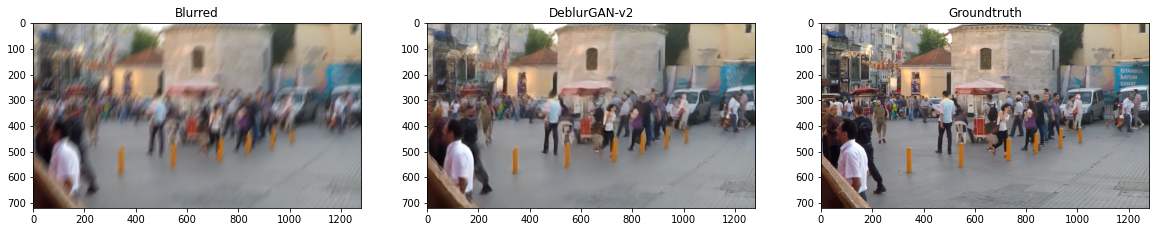

In [10]:
# Create subplot(r,c) by providing the no. of rows (r), number of columns (c) and figure size
f, ax = plt.subplots(1,3, figsize=(20, 15)) 

# Use the created array and display the images horizontally.
ax[0].set_title('Blurred')
ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

ax[1].set_title('DeblurGAN-v2')
ax[1].imshow(cv2.cvtColor(resized_result_image, cv2.COLOR_BGR2RGB))

ax[2].set_title('Groundtruth')
ax[2].imshow(cv2.cvtColor(groundtruth_image, cv2.COLOR_BGR2RGB))

### Save the deblurred image

Save the output image of the DeblurGAN-v2 model in the `output_dir` directory.

In [11]:
plt.imsave(output_dir / Path("000144_19.png"), cv2.cvtColor(resized_result_image, cv2.COLOR_BGR2RGB))